# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [2]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [3]:
# Your code here:
dc = customers.describe()
dc

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


In [5]:
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [6]:
cc = customers.corr()
cc[(cc > 0.8) & (cc < 1)].any()
# detergent x grocery

Channel             False
Region              False
Fresh               False
Milk                False
Grocery              True
Frozen              False
Detergents_Paper     True
Delicassen          False
dtype: bool

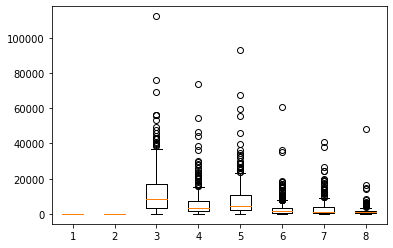

In [7]:
plt.boxplot(customers.values)
plt.show()

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [8]:
# Your code here
# checking outliers
out = customers[customers > dc.loc['75%']] 
#customers.drop(out.notnull())
[out[i].notnull().value_counts() for i in customers.columns], 110/440
# too much data loss (more than 25% of rows)

([False    440
  Name: Channel, dtype: int64, False    440
  Name: Region, dtype: int64, False    330
  True     110
  Name: Fresh, dtype: int64, False    330
  True     110
  Name: Milk, dtype: int64, False    330
  True     110
  Name: Grocery, dtype: int64, False    330
  True     110
  Name: Frozen, dtype: int64, False    330
  True     110
  Name: Detergents_Paper, dtype: int64, False    330
  True     110
  Name: Delicassen, dtype: int64], 0.25)

In [47]:
# checking only really high outliers
out = customers[customers > dc.loc['75%']*2 + dc.loc['std']]  
[out[i].notnull().value_counts() for i in customers.columns], out

([False    440
  Name: Channel, dtype: int64, False    440
  Name: Region, dtype: int64, False    431
  True       9
  Name: Fresh, dtype: int64, False    424
  True      16
  Name: Milk, dtype: int64, False    429
  True      11
  Name: Grocery, dtype: int64, False    424
  True      16
  Name: Frozen, dtype: int64, False    422
  True      18
  Name: Detergents_Paper, dtype: int64, False    432
  True       8
  Name: Delicassen, dtype: int64, False    440
  Name: labels, dtype: int64, False    440
  Name: dlabel, dtype: int64],
      Channel  Region  Fresh  Milk  Grocery   Frozen  Detergents_Paper  \
 0        NaN     NaN    NaN   NaN      NaN      NaN               NaN   
 1        NaN     NaN    NaN   NaN      NaN      NaN               NaN   
 2        NaN     NaN    NaN   NaN      NaN      NaN               NaN   
 3        NaN     NaN    NaN   NaN      NaN      NaN               NaN   
 4        NaN     NaN    NaN   NaN      NaN      NaN               NaN   
 ..       ...     ..

In [10]:
#removing them
#customers.drop()
len(np.where(out.notnull())[0])/440

0.17727272727272728

In [11]:
# Your comment here
# we would still get rid of almost 20% od the data, so i leave them for now

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [12]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:
customers_scale = StandardScaler().fit_transform(customers)

# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

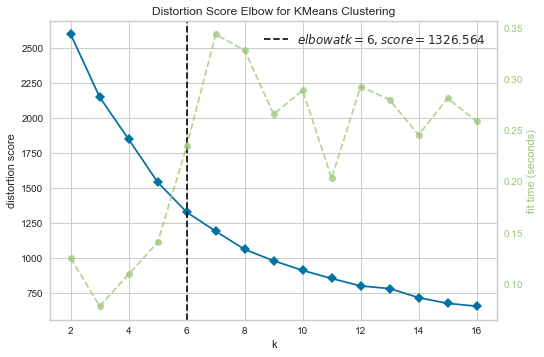

In [13]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,17))
visualizer.fit(customers_scale)
visualizer.poof()

In [14]:
# Your code here:
n_clusters = 2
cluster = KMeans(n_clusters=n_clusters)
model = cluster.fit(customers_scale)
customers['labels'] = model.labels_
# even though  the ideal would be 7 clusters, here we want to know if 20% of the customers
# are responsible for more than 80% of income, so i devided in two groups, one to represent
# the 20% of customers, and another to represent the rest.

Count the values in `labels`.

In [15]:
# Your code here:
customers['labels'].value_counts()

0    305
1    135
Name: labels, dtype: int64

# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [16]:
# Your code here
from sklearn.cluster import DBSCAN

cluster = DBSCAN(eps=0.5)
model = cluster.fit(customers_scale)
customers['dlabel'] = model.labels_

Count the values in `labels_DBSCAN`.

In [17]:
# Your code here
customers['dlabel'].value_counts()

-1    255
 1    130
 5     22
 4      7
 6      6
 2      5
 7      5
 3      5
 0      5
Name: dlabel, dtype: int64

# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

In [72]:
cluster = KMeans()
model = cluster.fit(customers_scale)
customers['labels'] = model.labels_

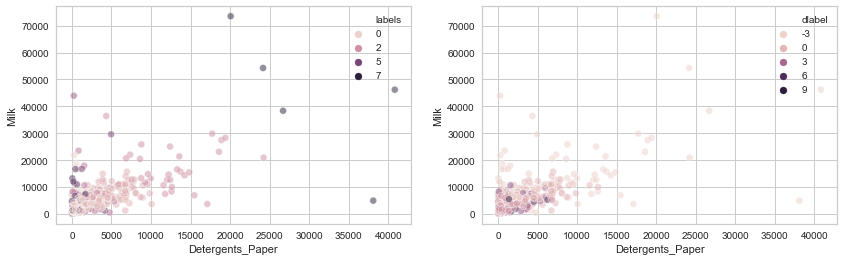

In [73]:
# Your code here:
import seaborn as sns
fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.scatterplot(customers['Detergents_Paper'], customers['Milk'], hue=customers['labels'], data=customers, alpha=0.5, ax=ax[0])
sns.scatterplot(customers['Detergents_Paper'], customers['Milk'], hue=customers['dlabel'], data=customers, alpha=0.5, ax=ax[1])


Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

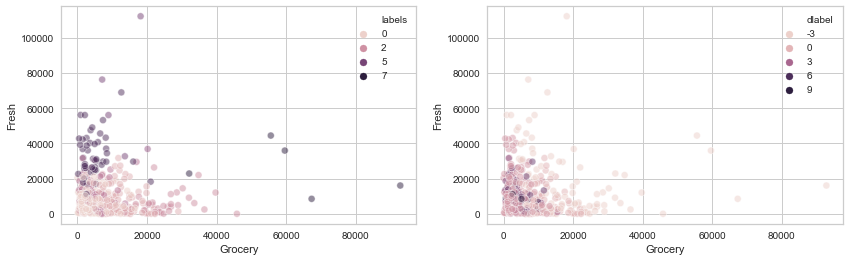

In [74]:
# Your code here:
fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.scatterplot(customers['Grocery'], customers['Fresh'], hue=customers['labels'], data=customers, alpha=0.5, ax=ax[0])
sns.scatterplot(customers['Grocery'], customers['Fresh'], hue=customers['dlabel'], data=customers, alpha=0.5, ax=ax[1])


Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

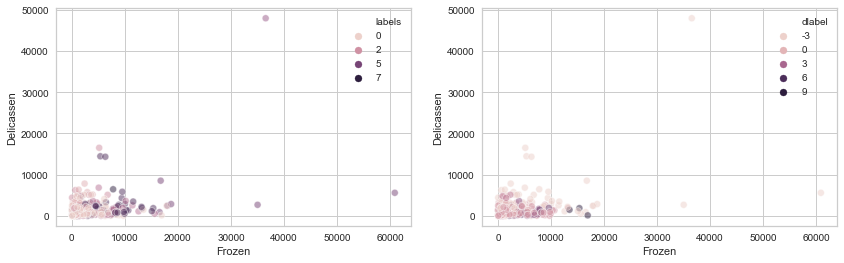

In [75]:
# Your code here:
fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.scatterplot(customers['Frozen'], customers['Delicassen'], hue=customers['labels'], data=customers, alpha=0.5, ax=ax[0])
sns.scatterplot(customers['Frozen'], customers['Delicassen'], hue=customers['dlabel'], data=customers, alpha=0.5, ax=ax[1])


Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [76]:
# Your code here:
customers.groupby(by='labels').agg({'mean'})

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,dlabel
,mean,mean,mean,mean,mean,mean,mean,mean,mean
labels,,,,,,,,,
0,1.000000,3.000000,7858.925926,2934.154321,3473.148148,2395.172840,808.240741,1000.012346,1.012346
1,2.000000,2.775510,8269.969388,7533.816327,11740.938776,1331.816327,4847.285714,1476.653061,0.173469
2,2.000000,2.281250,5985.437500,16817.625000,25628.656250,1840.000000,12321.750000,2455.093750,-0.906250
3,1.047619,1.297619,10105.940476,3214.654762,4098.702381,3146.892857,882.773810,1079.535714,3.547619
4,1.000000,3.000000,36847.000000,43950.000000,20170.000000,36534.000000,239.000000,47943.000000,-1.000000
5,1.000000,2.500000,53187.500000,10614.500000,9123.500000,27650.000000,1552.000000,3858.166667,-1.000000
6,1.057692,2.826923,32155.923077,3914.903846,4588.846154,5659.250000,654.173077,2122.096154,0.500000
7,2.000000,2.800000,25603.000000,43460.600000,61472.200000,2636.000000,29974.200000,2708.800000,-1.000000


In [77]:
customers.groupby(by='dlabel').agg({'mean'})

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels
,mean,mean,mean,mean,mean,mean,mean,mean,mean
dlabel,,,,,,,,,
-1,1.583333,2.291667,18715.708333,13122.906250,17235.260417,5730.895833,6776.500000,3258.135417,3.114583
0,2.000000,3.000000,7899.205128,7537.025641,11995.217949,1213.628205,5110.474359,1292.179487,1.038462
1,1.000000,3.000000,11357.460674,2555.808989,3142.280899,2575.224719,699.089888,922.848315,0.977528
2,1.000000,3.000000,5148.500000,4220.250000,3488.750000,1399.750000,781.250000,4702.250000,0.000000
3,2.000000,1.000000,2100.750000,7016.000000,10822.250000,1261.750000,5391.750000,911.000000,1.500000
4,1.000000,1.000000,9917.500000,2774.583333,3153.166667,2438.333333,809.083333,855.479167,3.000000
5,1.000000,2.000000,11458.440000,1836.400000,4000.880000,2872.880000,477.200000,947.560000,3.240000
6,2.000000,2.000000,6330.500000,3739.500000,7992.500000,792.500000,4173.500000,594.250000,1.000000


Which algorithm appears to perform better?

In [23]:
# Your observations here
# i guess it kind of depends on what i am using it for
# in this case, if i am checking for that 20% customers responsible for 80% revenue, than
# the kmean feels better, since i can choose to make the separation into two groups
# besides, the mean between the columns in the different groups are higher in the kmean
# or maybe we are just clustering the customers acording to what they buy

#after trying with 8 clusters in kmean, it seems a better fit than dbscan

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [54]:
# Your code here
# as seen before, it will perform better with 7 clusters (KElbowVisualizer)
# in the case we are clustering customers according to what they buy

n_clusters = 7
cluster = KMeans(n_clusters=n_clusters)

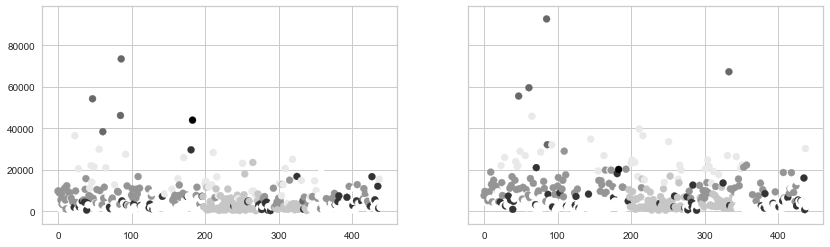

In [55]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

preds = cluster.fit_predict(customers_scale)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(14,4))
ax[0].scatter(customers.index, customers['Milk'], c=preds)
ax[1].scatter(customers.index, customers['Grocery'], c=preds)

plt.show()

In [26]:
# Your comment here
# feels messy

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

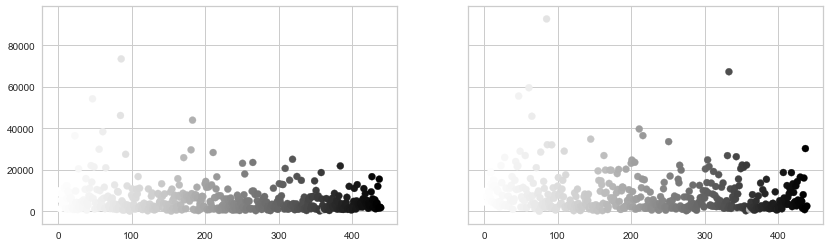

In [59]:
# Your code here
cluster = DBSCAN(eps=0.1, min_samples=1)
preds = cluster.fit_predict(customers_scale)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(14,4))
ax[0].scatter(customers.index, customers['Milk'], c=preds)
ax[1].scatter(customers.index, customers['Grocery'], c=preds)

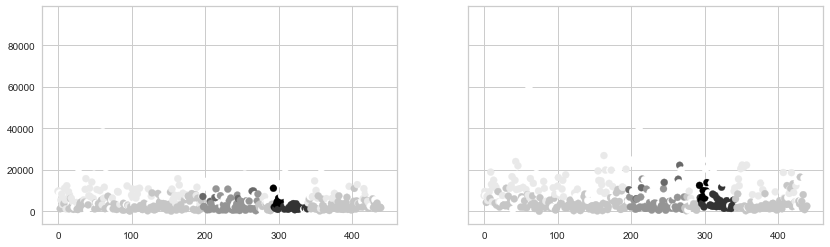

In [66]:
# Your comment here
cluster = DBSCAN(eps=1, min_samples=5)
preds = cluster.fit_predict(customers_scale)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(14,4))
ax[0].scatter(customers.index, customers['Milk'], c=preds)
ax[1].scatter(customers.index, customers['Grocery'], c=preds)

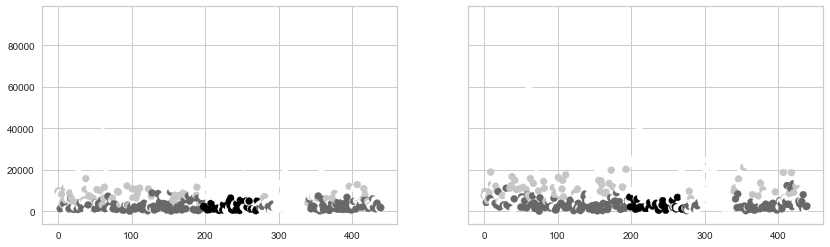

In [71]:
cluster = DBSCAN(eps=1, min_samples=30)
preds = cluster.fit_predict(customers_scale)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(14,4))
ax[0].scatter(customers.index, customers['Milk'], c=preds)
ax[1].scatter(customers.index, customers['Grocery'], c=preds)